In [1]:
%matplotlib inline
import numpy as np
from scipy.io import savemat
import matplotlib.pyplot as plt
import random
from joblib import Parallel, delayed
import pickle
import seaborn as sns
from mgcpy.independence_tests.dcorrx import DCorrX
from mgcpy.independence_tests.mgcx import MGCX
from mgcpy.independence_tests.xcorr import LjungBoxX, BoxPierceX
from mgcpy.benchmarks.ts_benchmarks import IndependentAR1, CorrelatedAR1, Nonlinear, EconometricProcess, NonlinearDependence, DynamicProcess

In [2]:
def _compute_power(test, X_full, Y_full, num_sims, alpha, n):
    """
    Helper method estimate power of a test on a given simulation.

    :param test: Test to profile, either DCorrX or MGCX.
    :type test: TimeSeriesIndependenceTest

    :param X_full: An ``[n*num_sims]`` data matrix where ``n`` is the highest sample size.
    :type X_full: 2D ``numpy.array``

    :param Y_full: An ``[n*num_sims]`` data matrix where ``n`` is the highest sample size.
    :type Y_full: 2D ``numpy.array``

    :param num_sims: number of simulation at each sample size.
    :type num_sims: integer

    :param alpha: significance level.
    :type alpha: float

    :param n: sample size.
    :type n: integer

    :return: returns the estimated power.
    :rtype: float
    """
    num_rejects = 0.0

    def worker(s):
        X = X_full[range(n), s]
        Y = Y_full[range(n), s]
        if test['name'] in ['DCorr-X', 'MGC-X']:
            p_value, _ = test['object'].p_value(X, Y, is_fast = test['is_fast'])
        else:
            p_value = test['object'].p_value(X, Y)

        if p_value <= alpha:
            return 1.0
        return 0.0

    rejects = Parallel(n_jobs=-2, verbose=0)(delayed(worker)(s) for s in range(num_sims))
    power = np.mean(rejects)
    std = np.std(rejects)

    return power, std

def _load_power_curves(tests, process):
    result = {}
    for test in tests:
        # Read in .pkl file.
        filename = f"./powers/{test['filename']}_powers_{process.filename}.pkl"
        pickle_in = open(filename,"rb")
        curve = pickle.load(pickle_in)
        pickle_in.close()
        
        N = curve.shape[0]
        if not result:
            result['sample_sizes'] = curve[:,0].reshape((N, 1))
        result[test['filename'] + '_powers'] = curve[:,1].reshape((N, 1))
        result[test['filename'] + '_stds'] = curve[:,1].reshape((N, 1))
    return result

def power_curve(tests, process, num_sims, alpha, sample_sizes, verbose = False):
    """
    Method to generate power curves for time series.

    :param tests: An array-like object containing TimeSeriesIndependenceTest objects.
    :type tests: 1-D array-like

    :param process: A TimeSeriesProcess object for which to profile the test.
    :type process: TimeSeriesProcess

    :param num_sims: number of simulation at each sample size.
    :type num_sims: integer

    :param alpha: significance level.
    :type alpha: float

    :param verbose: whether to display output.
    :type verbose: boolean

    :param sample_sizes: range of sample sizes for which to estimate power.
    :type sample_sizes: 1-D array-like
    """
    # Load simulated processes.
    filename = "%s_data.pkl" % (process.filename)
    pickle_in = open(filename,"rb")
    data = pickle.load(pickle_in)
    pickle_in.close()
    X_full = data['X']
    Y_full = data['Y']
    N = len(sample_sizes)

    for test in tests:
        if verbose: print(f"\nEstimating power for: {test['name']}")
        powers = np.zeros(N)
        stds = np.zeros(N)
        for i in range(N):
            n = sample_sizes[i]
            if verbose: print("Estimating power at sample size: {:3d}".format(n), end='\r')
            powers[i], stds[i] = _compute_power(test, X_full, Y_full, num_sims, alpha, n)
        test['powers'] = powers
        test['stds'] = stds
        
        # Save powers output.
        output = np.concatenate((sample_sizes.reshape((N,1)), test['powers'].reshape((N,1)), test['stds'].reshape((N,1))), axis=1)
        filename = "./powers/%s_powers_%s.pkl" % (test['filename'], process.filename)
        file = open(filename, 'wb')
        pickle.dump(output, file)
        file.close()

In [3]:
sample_sizes = np.arange(10, 201, 10)
alpha = 0.05
num_sims = 100

processes = [IndependentAR1(), CorrelatedAR1(), Nonlinear(), EconometricProcess(), NonlinearDependence()]
tests = [
    {
        'name' : 'DCorr-X',
        'filename' : 'dcorrx',
        'is_fast' : False,
        'subsample_size' : -1,
        'object' : DCorrX(max_lag=1)
    },
    {
        'name' : 'MGC-X',
        'filename' : 'mgcx',
        'is_fast' : False,
        'object' : MGCX(max_lag=1),
    },
    {
        'name' : 'LjungX',
        'filename' : 'ljungx',
        'object' : LjungBoxX(max_lag=1),
        'color' : 'k'
    },
    {
        'name' : 'BoxPierceX',
        'filename' : 'boxpiercex',
        'object' : LjungBoxX(max_lag=1),
        'color' : 'k'
    }
]

In [ ]:
for process in processes:
    power_curve(tests, process, num_sims, alpha, sample_sizes, verbose=True)


Estimating power for: DCorr-X


In [ ]:
def plot_power(tests, alpha, process, plot_errors = False, ax = None, figsize=(10, 6)):
    """
    Helper method to generate power curves for time series.

    :param tests: An array-like object containing TimeSeriesIndependenceTest objects.
    :type tests: 1-D array-like

    :param power_curve: range of sample sihttp://localhost:40572/notebooks/demos/time_series/time_series_demo.ipynb#zes for which to estimate power.
    :type power_curve: 1-D array-like

    :param alpha: significance level.
    :type alpha: float

    :param process: A TimeSeriesProcess object for which to profile the test.
    :type process: TimeSeriesProcess
    """
    curves = _load_power_curves(tests, process)
    
    with sns.plotting_context('talk'):
        if ax is None:
            fig, ax = plt.subplots(figsize=figsize)
        ax.set_title(process.name)
        ax.set_xlabel("n")
        ax.set_ylabel("Rejection Probability")
        ax.set_ylim((-0.05, 1.05))

        for test in tests:
            sample_sizes = curves['sample_sizes']
            powers = curves[test['filename'] + '_powers']
            stds = curves[test['filename'] + '_stds']
            errs = 1.96*np.divide(stds, np.sqrt(sample_sizes)).reshape(len(stds),)

            if plot_errors:
                ax.errorbar(
                    sample_sizes, 
                    powers, 
                    yerr=errs, 
                    alpha=0.7
                    #ecolor = test['color']
                )
            else:
                ax.plot(
                    sample_sizes, 
                    powers, 
                    linestyle = '-', 
                    #color = test['color']
                )
        ax.legend([test['name'] for test in tests], loc = 'upper left', prop={'size': 12})

        ax.axhline(y = alpha, color = 'black', linestyle = '--')
    plt.show()

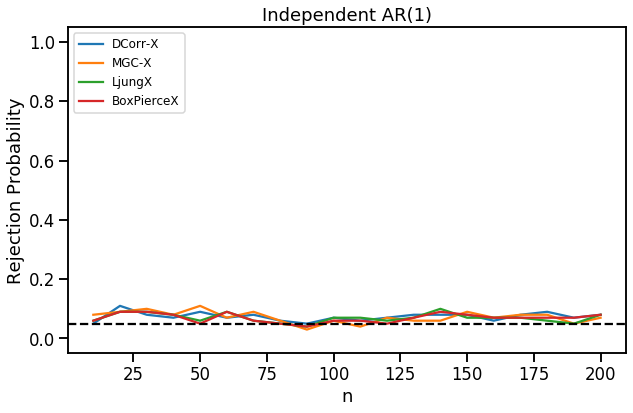

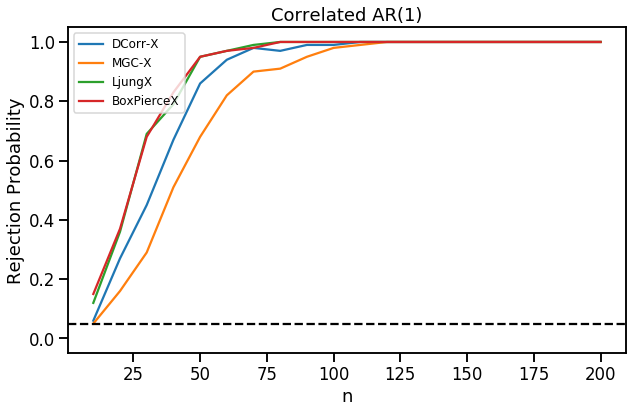

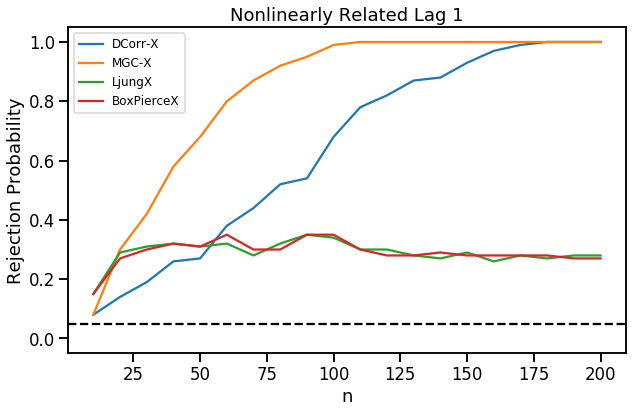

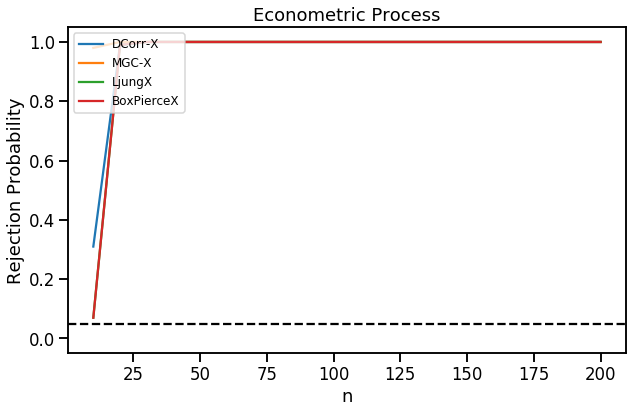

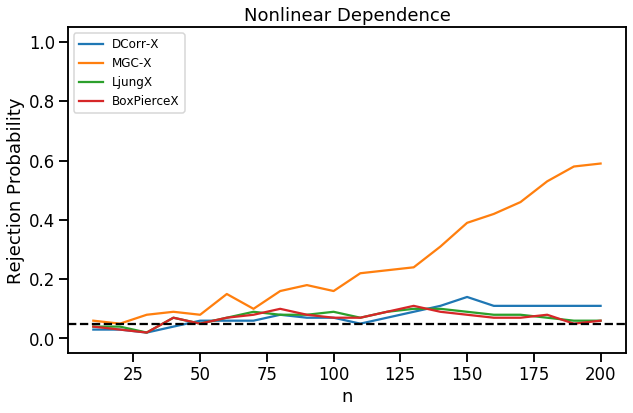

In [6]:
for process in processes:
    plot_power(tests, 0.05, process)